# 📊 Simple Linear Regression: TV Advertising vs Sales

A hands-on project exploring the impact of TV advertising on product sales using Simple Linear Regression, with visualizations, gradient descent, and Scikit-Learn.

## 🧠 Background

This portfolio project simulates a real-world data science consulting scenario. As statistical consultants, we are hired to investigate the relationship between **TV advertising budgets** and **product sales** across 200 different markets.

The dataset provides observations on the **TV advertising expenditures** and corresponding **sales figures** for a single product. The client has **full control over the TV advertising budget**, and the goal is to determine whether a change in spending can **predict or influence** sales performance.

<div class="alert alert-info" style="margin: 20px">
  While more complex models (e.g., KNN, Decision Trees, or ensemble methods) may be considered in other contexts, this project focuses on <strong>Simple Linear Regression</strong> due to its <strong>interpretability, foundational importance, and relevance in statistical learning</strong>.
</div>

---

## 🎯 Objective

- Determine whether a **linear relationship** exists between **TV advertising spending** and **sales**.
- Develop a **Simple Linear Regression model** to quantify the association.
- Evaluate the model's fit and reliability using appropriate metrics.
- Provide **business-oriented recommendations** on advertising strategies based on data analysis.
- Apply and compare **manual implementation**, **analytical solutions (OLS)**, and **Scikit-Learn's built-in LinearRegression model**.

---

## 📘 Learning Outcomes

By completing this project, the following skills and concepts will be demonstrated:

- Deep understanding of **Simple Linear Regression**, including:
  - Analytical approach using **Ordinary Least Squares (OLS)**
  - Manual parameter estimation using **Gradient Descent**
  - Cost function visualization and convergence diagnostics
- Application of industry-standard tools and libraries:
  - **Pandas** and **NumPy** for data handling and numerical computation
  - **Matplotlib** and **Seaborn** for data visualization and trend analysis
  - **Scikit-Learn** for building and evaluating regression models
- Model interpretation and evaluation:
  - **Coefficient and intercept analysis**
  - **R² Score**, **Mean Squared Error (MSE)**, and residual diagnostics
  - Understanding of **feature scaling** and its effect on gradient descent
- Business communication:
  - Translate technical results into clear, data-driven insights for strategic decision-making

---

# 1. Import Modules

In [4]:
import sys
import os

# Add project root to sys.path (one level up from "notebooks/")
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t
from spend_sale_lib.IQR import plot_iqr_outliers
from spend_sale_lib.OLS import Simple_OLS
from spend_sale_lib.Gradient_Descend import simple_gradient_descent

from sklearn.linear_model import LinearRegression

# 2. Load Dataset

| Feature        | Description                                                                                   |
|----------------|-----------------------------------------------------------------------------------------------|
| `Unnamed: 0`   | Additional index column. ✅ Confirmed with client that it can be safely **dropped**. (Discussed in Section 3(Histogram) and Section 4(Feature selection) )          |
| `TV`           | TV advertising spending. Unit: **thousands of dollars**.                                      |
| `Sales`        | Product sales quantity at the corresponding advertising budget. Unit: **thousands of units** *(not dollars)*. |

In [9]:
df = pd.read_csv('../data/Advertising_simple.csv')
df

,Unnamed: 0,TV,Sales
0,1,230.1,22.1
1,2,44.5,10.4
2,3,17.2,9.3
3,4,151.5,18.5
4,5,180.8,12.9
...,...,...,...
195,196,38.2,7.6
196,197,94.2,9.7
197,198,177.0,12.8
198,199,283.6,25.5


In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,200.0,100.5000,57.879185,1.0,50.750,100.50,150.250,200.0
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


# 3. Data Visualization

- A [histogram](https://www.atlassian.com/data/charts/histogram-complete-guide#:~:text=A%20histogram%20is%20a%20chart,value%20within%20the%20corresponding%20bin.) is a visual representation of the distribution of quantitative data.
- According to [Statistic Canada](https://www150.statcan.gc.ca/n1/edu/power-pouvoir/ch9/histo/5214822-eng.htm):" The histogram is a popular graphing tool. It is used to summarize discrete or continuous data that are measured on an interval scale. It is often used to illustrate the **major features of the distribution of the data** in a convenient form. It is also useful when dealing with large data sets (greater than 100 observations). It can help detect any **unusual observations (outliers)** or any gaps in the data."
- There is additional resource to help understanding histogram that provided from [wikipedia](https://en.wikipedia.org/wiki/Histogram). It also explain the how to select number of bins and width.

**TV Distribution (Left)**
- Same as before: 5 bins, each about 49.4 wide.
- Most TV advertising budgets fall between 200–250, showing a common tendency for higher ad spending.
- The distribution remains right-skewed: many markets invest moderately to heavily, but there’s still a fair number with minimal spending.

**Sales Distribution (Middle)**
- Distribution still appears roughly normal, with a slight left skew.
- Peak sales are around 12–14 units, with fewer markets achieving below ~5 or above ~25.
- The bell shape supports assumptions of normality in downstream regression models, which is ideal.

**“Unnamed: 0” Distribution (Right)**
- This plot shows a uniform flat distribution — each value occurs exactly once.
- Bin Size = 1, suggesting each bar corresponds to a unique value (like an index column).
- *Title Unnamed: 0 indicates this is likely the DataFrame’s index column accidentally included in the plot.* Need to confirm with clients for additional information

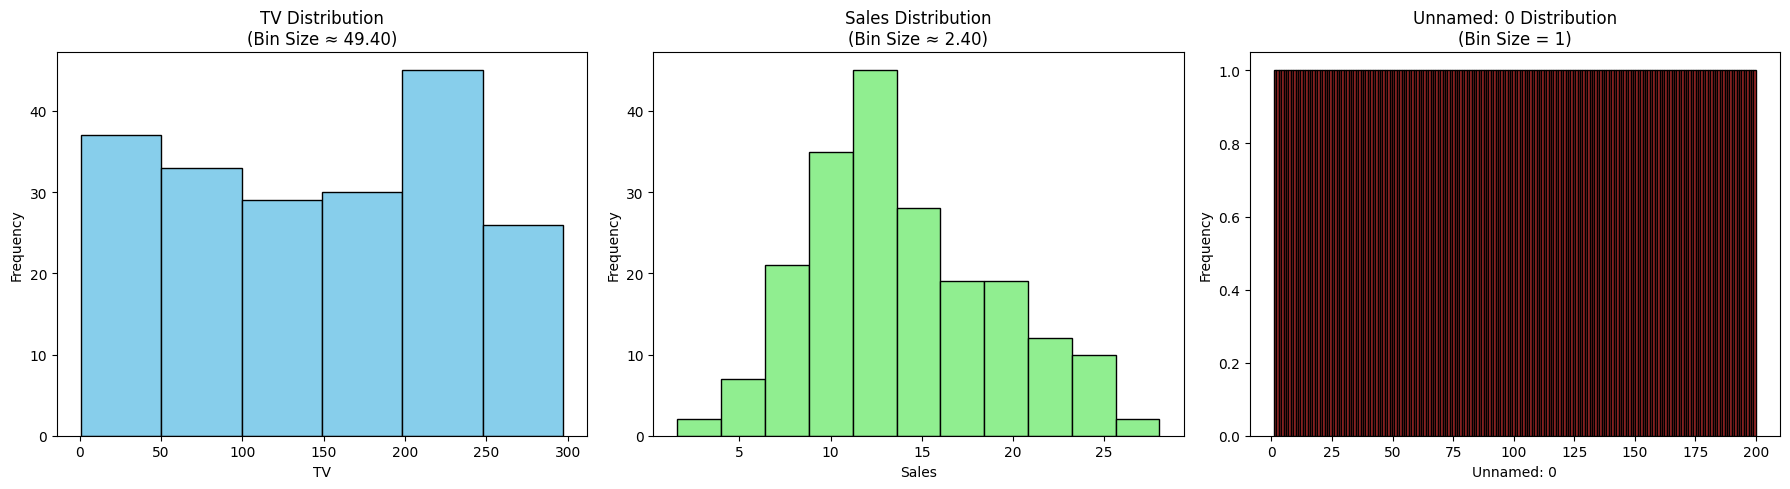

In [22]:
# Freedman–Diaconis rule function (returns bin edges and bin size)
def compute_bin_edges(data):
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(data) ** (1/3))
    if bin_width == 0:  # fallback
        bin_width = (data.max() - data.min()) / 10
    bins = np.arange(data.min(), data.max() + bin_width, bin_width)
    return bins, bin_width

# Compute bin edges and size
tv_bins, tv_bin_width = compute_bin_edges(df['TV'])
sales_bins, sales_bin_width = compute_bin_edges(df['Sales'])

# Plot
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(df['TV'], bins=tv_bins, color='skyblue', edgecolor='black')
plt.xlabel("TV")
plt.ylabel("Frequency")
plt.title(f"TV Distribution\n(Bin Size ≈ {tv_bin_width:.2f})")

plt.subplot(1, 3, 2)
plt.hist(df['Sales'], bins=sales_bins, color='lightgreen', edgecolor='black')
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.title(f"Sales Distribution\n(Bin Size ≈ {sales_bin_width:.2f})")

plt.subplot(1, 3, 3)
plt.hist(df['Unnamed: 0'], bins=200, color='brown', edgecolor='black')
plt.xlabel("Unnamed: 0")
plt.ylabel("Frequency")
plt.title(f"Unnamed: 0 Distribution\n(Bin Size = 1)")

plt.tight_layout()
plt.show()

# 4. Feature Selection

`Unnamed: 0` :
- It has no predictive power and should be excluded from further modeling.
- Including this in regression would be nonsensical, as it’s just an identifier, not an input variable.
- Confirmed with client that  can be safely **dropped**. 

In [23]:
# drop feature 'Unnamed:0'
df = df.drop(['Unnamed: 0'], axis=1)
df

,TV,Sales
0,230.1,22.1
1,44.5,10.4
2,17.2,9.3
3,151.5,18.5
4,180.8,12.9
...,...,...
195,38.2,7.6
196,94.2,9.7
197,177.0,12.8
198,283.6,25.5


# 5. Check Noise and Denoise

The Interquartile Range (IQR) method was used to detect potential noise in the dataset. [See explanation on Wikipedia](https://en.wikipedia.org/wiki/Interquartile_range).

The Interquartile Range (IQR) is defined as:

$$
\text{IQR} = Q_3 - Q_1
$$

Where:
- \( Q_1 \) = First quartile (25th percentile)
- \( Q_3 \) = Third quartile (75th percentile)

To detect outliers, we use the following bounds:

- **Lower bound**:  
  $$
  \text{Lower} = Q_1 - 1.5 \times \text{IQR}
  $$

- **Upper bound**:  
  $$
  \text{Upper} = Q_3 + 1.5 \times \text{IQR}
  $$

Any data point outside this range is considered a potential outlier.

<div align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1200/1*0MPDTLn8KoLApoFvI0P2vQ.png" alt="IQR" width="700" height="350"/>
</div>

- After applying the IQR-based filtering, we found no potential outliers, indicating that the dataset is clean and free of significant noise.

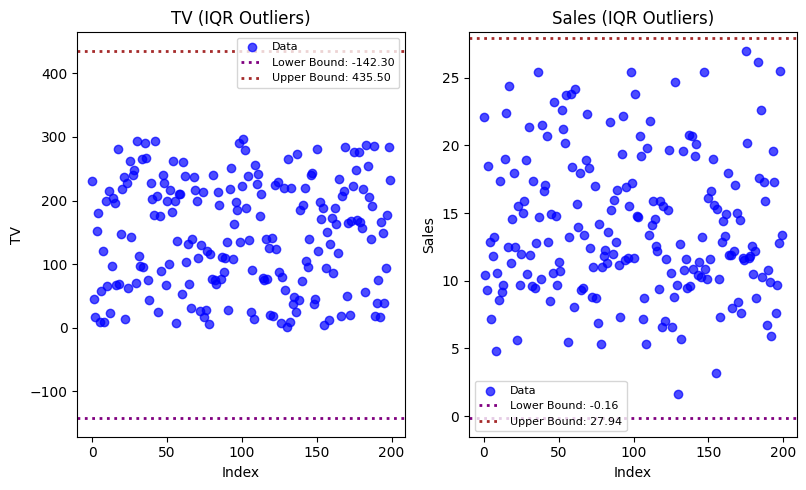

In [24]:
plot_iqr_outliers(df)  # all features

# 6. TV V.S. Sales Correlation

Before applying linear regression, it’s essential to assess whether a linear relationship exists between the independent variable (TV advertising spend) and the dependent variable (Sales). This can be evaluated using the Pearson correlation coefficient, which measures the strength and direction of a linear association between two variables.

The Pearson correlation coefficient \( r \) between variables \( X \) and \( Y \) is defined as:

$$
r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}
         {\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}}
$$

where:
- $ X_i, Y_i$ are the individual sample points,
- $\bar{X}$, $\bar{Y}$ are the sample means of $X$ and $Y$,
- $n$ is the number of observations.

<div align="center">
  <img src="https://www.simplypsychology.org/wp-content/uploads/correlation-coefficient.jpg" alt="IQR" width="700" height="350"/>
</div>

- In our analysis, the **correlation coefficient between TV spending and Sales is 0.7822**, indicating a **strong positive relationship**.
- Since **0.7822** is **significantly greater than 0.7**, it is commonly interpreted as **strong evidence of a linear association** in statistical practice. This provides a **solid foundation for using simple linear regression**, where we model Sales as a linear function of TV advertising expenditure.

**Common References Supporting the 0.7 Threshold**

1.	[Cohen’s Guidelines (1988)](https://academic.oup.com/innovateage/article/3/4/igz036/5560156)

    In behavioral sciences, Jacob Cohen proposed general guidelines:
    - Small: r = 0.10
    - Medium: r = 0.30
    - Large: r = 0.50 or above

    While Cohen was focused on psychology, his framework influenced many applied fields.

2. Mukaka (2012) – “[A guide to appropriate use of correlation coefficient in medical research](https://pmc.ncbi.nlm.nih.gov/articles/PMC3576830/)”

    Published in Malawi Medical Journal, this article discusses similar thresholds:
    - $0.7 \leq r < 0.9$: Strong
    - $0.9 \leq r \leq 1.0$: Very strong

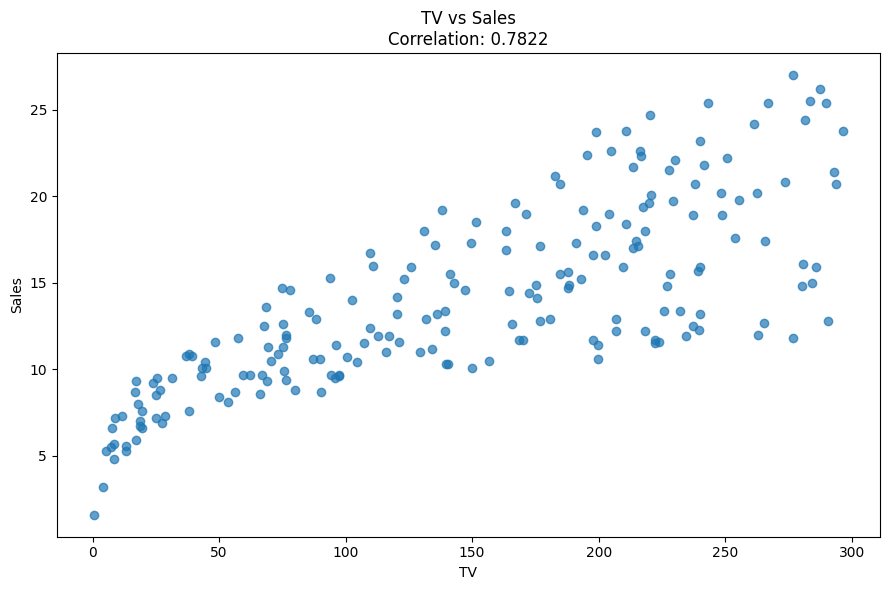

In [6]:
# Calculate correlation
tv_corr = df['TV'].corr(df['Sales'])

# Plot
plt.figure(figsize=(9, 6))
plt.scatter(df['TV'], df['Sales'], alpha=0.7)
plt.xlabel("TV")
plt.ylabel("Sales")
plt.title(f"TV vs Sales\nCorrelation: {tv_corr:.4f}")
plt.tight_layout()
plt.show()

# Linear Regression

We will calculate the most optimized coefficient by doing multiple approach:
- Manually calculating Ordinary Least Square(OLS).
- NumPy
- Scikit-Learn

## Manually Calculate OLS

We are modeling the relationship between variables X and Y using:

$$\hat{y}_i = \beta_0 + \beta_1 x_i$$

We want to find the best $\beta_0$ (intercept) and $\beta_1$ (slope) such that the sum of squared errors (SSE) is minimized The Cost Function:

$$S(\beta_0, \beta_1) = \sum_{i=1}^n (y_i - \hat{y}i)^2 = \sum_{i=1}^n (y_i - \beta_0 - \beta_1 x_i)^2$$

**Partial Derivative with respect to $\beta_0$:**

$$\frac{\partial S}{\partial \beta_0} = -2 \sum_{i=1}^{n} (y_i - \beta_0 - \beta_1 x_i) = 0$$

$$n \beta_0 + \beta_1 \sum x_i = \sum y_i$$

$$
\text{Where } n\bar{x} = \sum x_i \quad \text{and} \quad n\bar{y} = \sum y_i
$$

$${n}\beta_0 = {n}\bar{y} - {n}\beta_1 \bar{x}$$

$$
\boxed{
\beta_0 = \bar{y} - \beta_1 \bar{x}
}
$$

$$\beta_0 = \bar{y} - \beta_1 \bar{x} \quad \text{→ Equation (1)}$$

**Partial Derivative with respect to $\beta_1$:**

$$\frac{\partial S}{\partial \beta_1} = -2 \sum_{i=1}^{n} x_i (y_i - \beta_0 - \beta_1 x_i) = 0$$

$$\sum x_i y_i - \beta_0 \sum x_i - \beta_1 \sum x_i^2 = 0 \quad \text{→ Equation (2)}$$

Now, substitute **Equation (1)** $(\beta_0 = \bar{y} - \beta_1 \bar{x})$ into **Equation (2)**.

$$\sum x_i y_i - \bar{y} \sum x_i + \beta_1 \bar{x} \sum x_i - \beta_1 \sum x_i^2 = 0$$

$$\sum x_i y_i - \bar{y} \sum x_i + \beta_1 \left( \bar{x} \sum x_i - \sum x_i^2 \right) = 0$$

$$\sum x_i y_i - n \bar{x} \bar{y} + \beta_1 \left( n \bar{x}^2 - \sum x_i^2 \right) = 0$$

$$\beta_1 \left( n \bar{x}^2 - \sum x_i^2 \right) = n \bar{x} \bar{y} - \sum x_i y_i$$

Multiply both sides by -1 to get positive denominators:

$$\beta_1 \left( \sum x_i^2 - n \bar{x}^2 \right) = \sum x_i y_i - n \bar{x} \bar{y}$$

$$
\boxed{
\beta_1 = \frac{\sum x_i y_i - n \bar{x} \bar{y}}{\sum x_i^2 - n \bar{x}^2}
}
$$

$$\sum (x_i - \bar{x})(y_i - \bar{y}) = \sum x_i y_i - \bar{y} \sum x_i - \bar{x} \sum y_i + n \bar{x} \bar{y}$$

$$\sum (x_i - \bar{x})(y_i - \bar{y})
= \sum x_i y_i - \bar{y} (n \bar{x}) - \bar{x} (n \bar{y}) + n \bar{x} \bar{y}
= \sum x_i y_i - n \bar{x} \bar{y} - n \bar{x} \bar{y} + n \bar{x} \bar{y}
= \sum x_i y_i - n \bar{x} \bar{y}$$

$$\sum (x_i - \bar{x})^2
= \sum x_i^2 - 2\bar{x} \sum x_i + n \bar{x}^2
= \sum x_i^2 - 2\bar{x} (n \bar{x}) + n \bar{x}^2
= \sum x_i^2 - 2n \bar{x}^2 + n \bar{x}^2
= \sum x_i^2 - n \bar{x}^2
$$

This is also equivalent to:

$$
\boxed{
\beta_1 = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}
}
$$

**Final OLS Estimators:**

$$
\boxed{\beta_1 = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}}
\quad , \quad
\boxed{\beta_0 = \bar{y} - \beta_1 \bar{x}}
$$

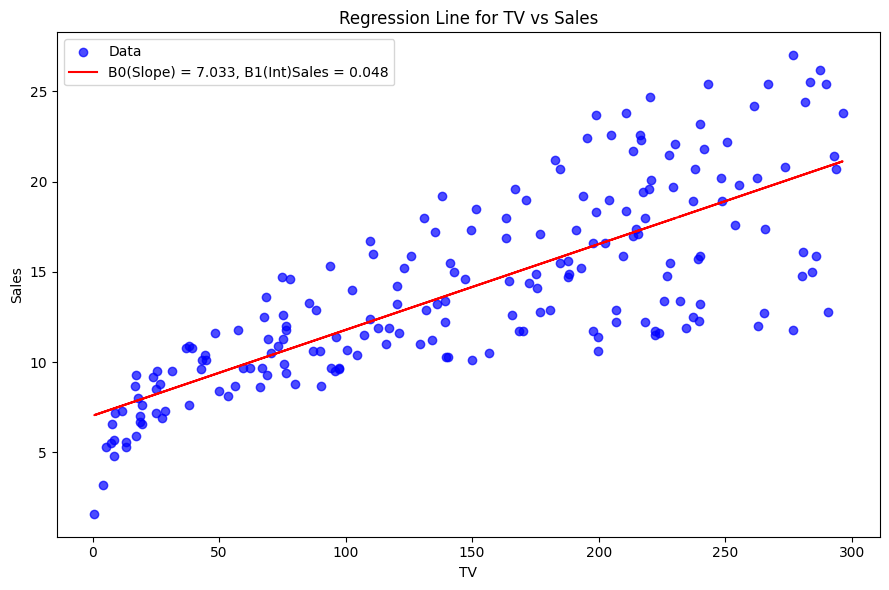

In [7]:
plt.figure(figsize=(9, 6))
feature = 'TV'
B0_slope, B1_int = Simple_OLS(df, feature, 'Sales')
plt.scatter(df[feature], df['Sales'], color='blue', label='Data', alpha=0.7)
equation_label = f"B0(Slope) = {B0_slope:.3f}, B1(Int)Sales = {B1_int:.3f}"
plt.plot(df[feature], B0_slope + B1_int * df[feature], color='red', label=equation_label)
plt.xlabel(f'{feature}')
plt.ylabel('Sales')
plt.title(f'Regression Line for {feature} vs Sales')
plt.legend()
plt.tight_layout()
plt.show()

## Manually Calculate Gradient Descend

We want to minimize the cost function, typically the Mean Squared Error (MSE):

$$J(\beta_0, \beta_1) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\quad \text{where} \quad \hat{y}_i = \beta_0 + \beta_1 x_i$$

We use partial derivatives of the cost function J to update $\beta_0$ and $\beta_1$:

$$
\boxed{
\beta_0 := \beta_0 - \alpha \cdot \frac{\partial J}{\partial \beta_0}
}
\quad , \quad
\boxed{
\beta_1 := \beta_1 - \alpha \cdot \frac{\partial J}{\partial \beta_1}
}
$$

Where $\alpha$ is the learning rate.

1. Derivative w.r.t. $\beta_0$:

$$\frac{\partial J}{\partial \beta_0} = -\frac{2}{n} \sum_{i=1}^{n} (y_i - \beta_0 - \beta_1 x_i)= -\frac{2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)$$

2. Derivative w.r.t. $\beta_1$:

$$\frac{\partial J}{\partial \beta_1} = -\frac{2}{n} \sum_{i=1}^{n} (y_i - \beta_0 - \beta_1 x_i) \cdot x_i = -\frac{2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) \cdot x_i$$


Feature: TV
  Optimized B0 (Intercept): 7.0176
  Optimized B1 (Slope):     0.0474


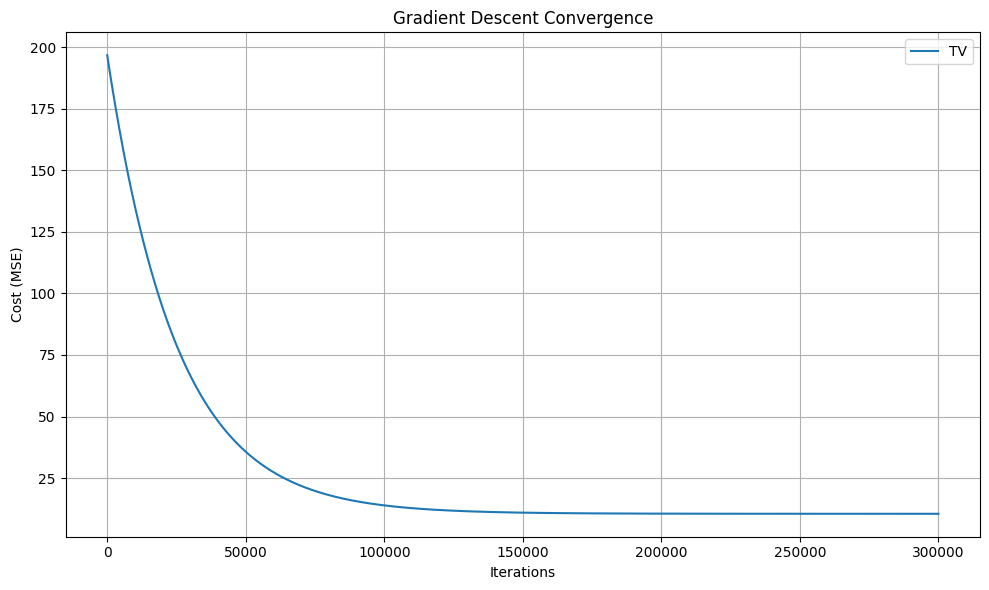

In [9]:
estimators = simple_gradient_descent(df=df, target='Sales', feature='TV',alpha=0.00001, epochs=300000,init_B0=1, init_B1=0, plot=True)

## NumPy

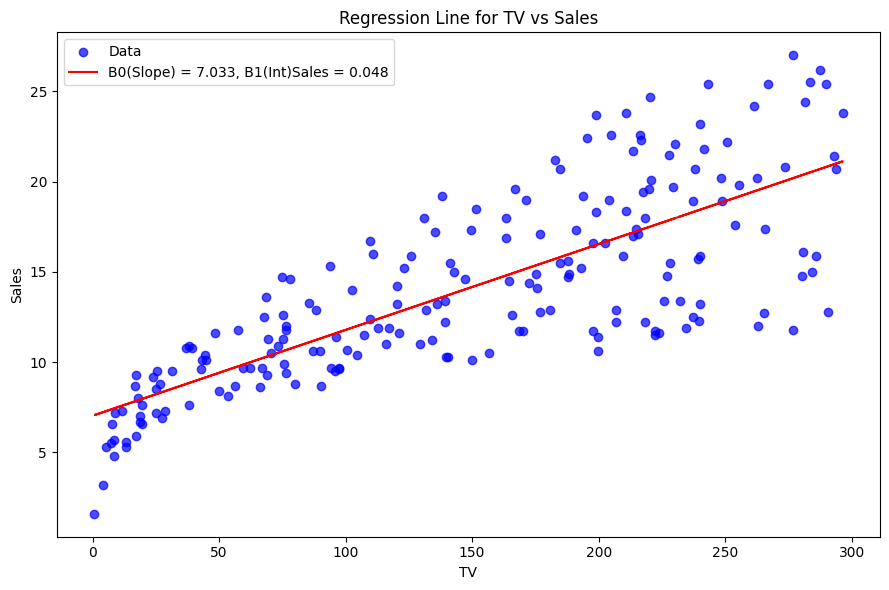

In [13]:
plt.figure(figsize=(9, 6))
y = df['Sales']
feature = 'TV'
X = df[feature]
B1, B0 = np.polyfit(X,y,deg=1) # sovling 1st degree polynomial function to find B1 and B0
plt.scatter(df[feature], df['Sales'], color='blue', label='Data', alpha=0.7)
equation_label = f"B0(Slope) = {B0:.3f}, B1(Int)Sales = {B1:.3f}"
plt.plot(df[feature], B0 + B1 * df[feature], color='red', label=equation_label)
plt.xlabel(f'{feature}')
plt.ylabel('Sales')
plt.title(f'Regression Line for {feature} vs Sales')
plt.legend()
plt.tight_layout()
plt.show()

## Scikit-Learning

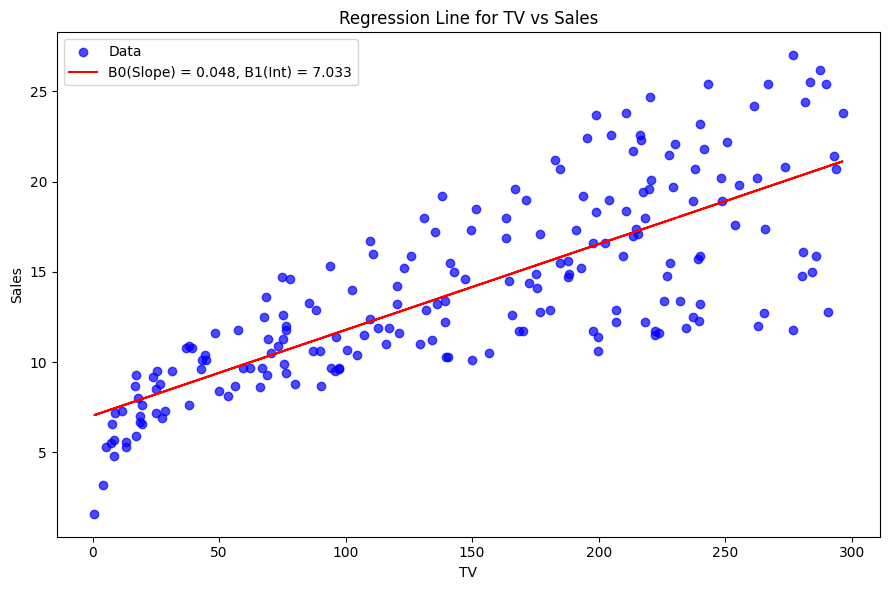

In [15]:
plt.figure(figsize=(9, 6))
y = df['Sales']
feature = 'TV'
X = df[[feature]]  # 2D shape required for sklearn
model = LinearRegression()
model.fit(X, y)

B0 = model.intercept_
B1 = model.coef_[0]

plt.scatter(df[feature], y, color='blue', label='Data', alpha=0.7)

equation_label = f"B0(Slope) = {B1:.3f}, B1(Int) = {B0:.3f}"
plt.plot(df[feature], model.predict(X), color='red', label=equation_label)

plt.xlabel(f'{feature}')
plt.ylabel('Sales')
plt.title(f'Regression Line for {feature} vs Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Model Evaluation

## Residual Standard Error(RSE) and $R^2$ Statistic

- Actual sales in the market deviate from the true regression line by 3260 Units, on average.
- If coefficient(B0 & B1) are accurate, the prediction of sales on the basis of TV advertising would still be off 3260 units.
- Whether or not 3260 units is an acceptable prediction error depends on the problem context.
- The average value of sales is around 14,000 units, and so the percentage error is 3260/14000 = 23%.

In [13]:
y = df['Sales']
metrics_list = []
feature = 'TV'
X = df[[feature]]
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
B0 = model.intercept_
B1 = model.coef_[0]

n = len(y)
mse = mean_squared_error(y, y_pred)
rse = np.sqrt(mse * n / (n - 2))
r2 = r2_score(y, y_pred)
metrics_list.append((feature, rse, r2))

# 打印每个特征的 RSE 和 R²
print(f"{feature} - RSE: {rse:.3f}, R²: {r2:.3f}")

TV - RSE: 3.259, R²: 0.612


# Evaluate Coefficient Accuracy and Confidence Interval

In [14]:
# 假设 df 包含 'Sales' 和 3 个特征
feature = 'TV'
x = df[feature]
y = df['Sales']
x_mean = x.mean()
y_mean = y.mean()

x_diff = x - x_mean
y_diff = y - y_mean

B1 = (x_diff * y_diff).sum() / (x_diff ** 2).sum()
B0 = y_mean - B1 * x_mean

# 预测和残差
y_pred = B1 * x + B0
residuals = y - y_pred
n = len(df)

RSS = (residuals ** 2).sum()
RSE = np.sqrt(RSS / (n - 2))

SE_B1 = RSE / np.sqrt((x_diff ** 2).sum())
SE_B0 = RSE * np.sqrt((1 / n) + (x_mean ** 2 / (x_diff ** 2).sum()))

# 置信区间范围（近似 95%）
B1_low, B1_high = B1 - 2 * SE_B1, B1 + 2 * SE_B1
B0_low, B0_high = B0 - 2 * SE_B0, B0 + 2 * SE_B0

print(f"\nFeature: {feature}")
print(f"  Slope (B1): {B1:.4f}, Intercept (B0): {B0:.4f}")
print(f"  SE of B1: {SE_B1:.4f}, SE of B0: {SE_B0:.4f}")
print(f"  B1 range: [{B1_low:.4f}, {B1_high:.4f}]")
print(f"  B0 range: [{B0_low:.4f}, {B0_high:.4f}]")


Feature: TV
  Slope (B1): 0.0475, Intercept (B0): 7.0326
  SE of B1: 0.0027, SE of B0: 0.4578
  B1 range: [0.0422, 0.0529]
  B0 range: [6.1169, 7.9483]


# Hypothesis Test

In [16]:
feature = 'TV'
y = df['Sales']
n = len(y)
dof = n - 2  # 自由度

X = df[feature].values.reshape(-1, 1)

# 训练模型
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

RSS = np.sum((y - y_pred) ** 2)
RSE = np.sqrt(RSS / dof)

# 标准误差
x_diff_sq_sum = np.sum((X - np.mean(X)) ** 2)
SE_B1 = RSE / np.sqrt(x_diff_sq_sum)
SE_B0 = RSE * np.sqrt((1 / n) + (np.mean(X) ** 2 / x_diff_sq_sum))

# t 值
B1 = model.coef_[0]
B0 = model.intercept_
t_B1 = B1 / SE_B1
t_B0 = B0 / SE_B0

# p 值（双尾）
p_B1 = 2 * (1 - t.cdf(np.abs(t_B1), df=dof))
p_B0 = 2 * (1 - t.cdf(np.abs(t_B0), df=dof))

# 输出
print(f"\nFeature: {feature}")
print(f"  B1 (Slope) = {B1:.4f}, SE_B1 = {SE_B1:.4f}, t = {t_B1:.4f}, p = {p_B1:.4e}")
print(f"  B0 (Intercept) = {B0:.4f}, SE_B0 = {SE_B0:.4f}, t = {t_B0:.4f}, p = {p_B0:.4e}")

if p_B1 < 0.05:
    print("  ✅ Slope is statistically significant (reject H0)")
else:
    print("  ❌ Slope is NOT statistically significant (fail to reject H0)")


Feature: TV
  B1 (Slope) = 0.0475, SE_B1 = 0.0027, t = 17.6676, p = 0.0000e+00
  B0 (Intercept) = 7.0326, SE_B0 = 0.4578, t = 15.3603, p = 0.0000e+00
  ✅ Slope is statistically significant (reject H0)
